# Exercise 6
## Fundamentals of Machine Learning, WiSe 20/21
### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl
    Version information:
        2021-02-20: v.1.0. First public release. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from scipy.ndimage import gaussian_filter
from sklearn.datasets import load_digits 
from sklearn.model_selection import train_test_split

# Produce inline vector graphics
%config InlineBackend.figure_format = 'svg'

# 3. Denoising a CT image (11 pts)

In [2]:
def construct_X(M, alphas, Np=None, tau=0):
    '''
    Construct the matrix X of weights corresponding to the linear system of equations
    X*Beta = y, where Beta and y are vectors.
    
    Parameters
    ----------
    M: int
        One-sided length of the square tomogram. Full size of tomogram is D = M*M. 
    alphas: list
        List of measurement angles alpha, in degrees.
    Np: int
        Resolution of sensor array, optional.
    Returns:
    --------
    scipy.sparse.coo.coo_matrix 
        The constructed matrix X in sparse format.
    '''
    # Pixel spacing in tomography image and in sensor array.
    h = 1  
    
    # If no sensor resolution is given, set a large enough value to cover image.
    if Np == None:
        Np = np.ceil(np.sqrt(2)*M)
    
    D = int(M*M)               # Pixel count in tomography image.
    N = int(Np * len(alphas))  # Number of measured responses y_i.
    
    # Convert angles to radians.
    alphas_rad = np.radians(alphas) 
    
    # Construct unit vectors from the alphas.
    n = np.array([np.cos(alphas_rad), -np.sin(alphas_rad)]) # shape=(2,len(alphas))
    
    # Geometrical center of tomography image.
    geo_center = (M/2 - 0.5)*h           
    
    # Construct matrix with center coordinates for all pixels.
    linpos = h*np.arange(M) - geo_center             # 1D position vector.
    x_pos, y_pos = np.meshgrid(linpos, linpos)       # 2D meshgrid.
    C = np.array([x_pos.flatten(), y_pos.flatten()]) # Pixel centers, shape=(2,D).
    
    # Distance from first element in sensor to sensor origin.
    s0 = (Np/2 - 0.5)*h 
    
    # Find the pixel projections on the sensor.
    p = (n.T @ C) + s0 
    
    # Matrices of indices. 
    p_idx = np.indices(p.shape)
    
    # Pixel index j from where ray originates. 
    j_low  = p_idx[1]
    j_high = p_idx[1]
    
    # Sensor indices i where ray intersects sensor array. 
    i_low  = np.floor(p/h) + p_idx[0] * Np
    i_high = np.ceil(p/h)  + p_idx[0] * Np
    
    # Fractional coverage of ray from pixel j at sensor i.
    weights_high = p/h - np.floor(p/h)
    weights_low  = 1 - weights_high
    
    # Concatenate arrays.
    i_idx   = np.concatenate((i_low.flatten(), i_high.flatten()))
    j_idx   = np.concatenate((j_low.flatten(), j_high.flatten()))
    weights = np.concatenate((weights_low.flatten(), weights_high.flatten()))
    
    # Convert to integer datatype.
    i_idx = i_idx
    j_idx = j_idx
    
    # If chosen, add regularization. (Remember to add corresponding zeros to y!)
    if tau != 0:
        j = np.arange(D)
        i = N + np.arange(D)
        w = np.ones_like(i)*np.sqrt(tau)
        i_idx   = np.concatenate((i_idx, i))
        j_idx   = np.concatenate((j_idx, j))
        weights = np.concatenate((weights, w))
        N += D 
    
    # Form sparse matrix.
    X = coo_matrix((weights, (i_idx.astype(int), j_idx.astype(int))), shape=(N,D), dtype=np.float32)
    
    return X

In [3]:
# Higher resolution image
M        = 195  # 1d size of the square tomogram. Full size is D = M*M.
Np       = 275  # Length of (1d) sensor array.
alphas   = np.load('hs_tomography/alphas_195.npy')
y        = np.load('hs_tomography/y_195.npy')

In [4]:
# Construct CT image based on 64 projection angles.
doses      = 64
index      = [int(np.ceil(i*len(alphas)/doses)) for i in range(doses)]
alphas_sub = alphas[index]
y_sub      = np.zeros((doses*Np))
for i,j in enumerate(index):
    y_sub[i*Np:(i+1)*Np] = y[j*Np:(j+1)*Np]
    
# Construct X matrix.
X_sub = construct_X(M, alphas_sub, Np=Np, tau=0).tocsc()

# Solving for Beta.
beta, istop, itn, r1norm = lsqr(X_sub, y_sub, atol=1e-05, btol=1e-05)[:4]
print(istop, itn, r1norm)

# Save result.
beta_tau0 = beta.copy()

1 120 159.16571734557496


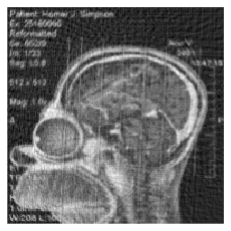

In [5]:
# Plotting the resulting X-ray image.
plt.figure(figsize=(4,4))
plt.imshow(beta.reshape(M, M))
plt.axis('off')
plt.show()

With regularization:

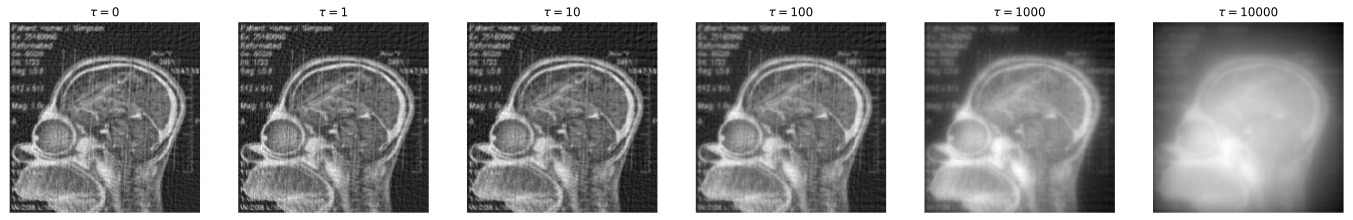

In [6]:
taus = [0, 1, 10, 100, 1000, 10000]

fig, ax = plt.subplots(1, len(taus), figsize=(len(taus)*4, 4))
ax = ax.flatten()
for i, tau in enumerate(taus):
    # Construct X matrix.
    X = construct_X(M, alphas_sub, Np=Np, tau=tau).tocsc()
    if tau == 0:
        y = y_sub
    else:
        y = np.concatenate((y_sub, np.zeros(M**2)))

    # Solving for Beta.
    beta, istop, itn, r1norm = lsqr(X, y, atol=1e-05, btol=1e-05)[:4]
    #print(istop, itn, r1norm)

    # Plotting the resulting X-ray image.
    ax[i].imshow(beta.reshape(M, M))
    ax[i].set_title(f'$\\tau = {{{tau}}}$')
    ax[i].axis('off')
plt.show()

Gaussian filtering on unregularized CT image:

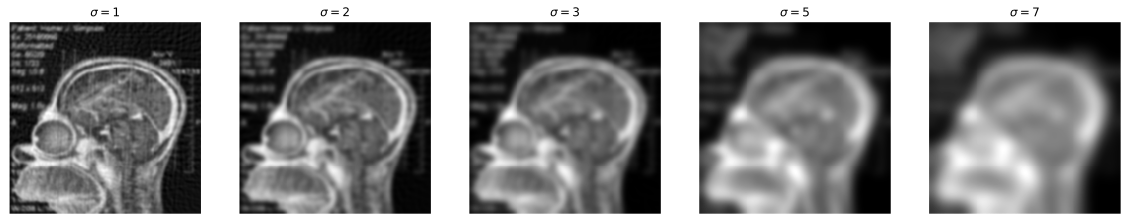

In [7]:
sigmas = [1,2,3,5,7]
fig, ax = plt.subplots(1, len(sigmas), figsize=(len(sigmas)*4, 4))
ax = ax.flatten()
for i, sigma in enumerate(sigmas):
    beta_filtered = gaussian_filter(beta_tau0.reshape(M,M), sigma)
    # Plotting the resulting X-ray image.
    ax[i].imshow(beta_filtered)
    ax[i].set_title(f'$\sigma = {{{sigma}}}$')
    ax[i].axis('off')
plt.show()

# 4. Automatic feature selection for regression
## 4.1 Implement Orthogonal Matching Pursuit (5 pts)

In [8]:
def omp_regression(X, y, T):
    '''
    Orthogonal matching pursuit.
    
    Parameters:
    -----------
    X: np.array shape=(N,D)
    y: np.array shape=(N,)
    T: int 
    
    Returns:
    --------
    solutions: np.array shape=(D,T)
    
    '''
    N,D = X.shape
    A = []                      # Active set 
    B = [j for j in range(D)]   # Inactive set
    r = y                       # Initial residual
    beta_hat = np.zeros((D, T))
    for t in range(T):
        # Find the inactive column that has maximum correlation
        # with the current residual.
        j = np.argmax(np.abs(X[:,B].T.dot(r)))
        
        # Move j from the inactive to the active set.
        A.append(B.pop(j))
        
        # Form the active matrix
        X_active = X[:,A]
        
        # Solve the least squares problem
        beta = lsqr(X_active, y)[:1][0]
        r = y - X_active.dot(beta)
        
        # Add beta to the solutions
        beta_hat[A,t] = beta 
    
    return beta_hat

## 4.2 Classification with sparse LDA (8 pts)

In [9]:
# Importing the digits dataset
digits = load_digits()
data   = digits["data"]
target = digits["target"]

In [10]:
def LDA_data(data, target, num1=1, num2=7, test_frac=0.33, rand_seed=0):
    '''
    Generate test and training sets from two digits.
    '''
    # Filter out the select digits and relabel targets.
    mask = (target == num1) | (target == num2)
    data   = data[mask] 
    target = target[mask]
    target[target == num1] = 1
    target[target == num2] = -1

    # Random split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_frac, 
                                                        random_state=rand_seed)
    # Standardize data.
    train_std  = np.std(X_train, axis=0)+1e-99   # Std over all instances.
    train_mean = np.mean(X_train, axis=0)        # Mean over all instances.
    X_train_std = (X_train - train_mean)/train_std
    X_test_std  = (X_test - train_mean)/train_std

    return X_train, X_train_std, X_test, X_test_std, y_train, y_test

In [11]:
X_train, X_train_std, X_test, X_test_std, y_train, y_test = LDA_data(data, target)

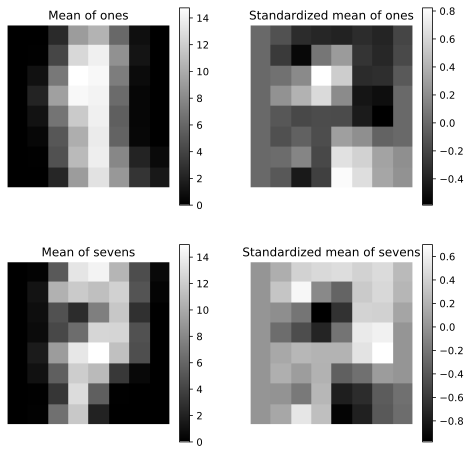

In [12]:
plt.figure(figsize=(8,8))
#----------
plt.subplot(221)
plt.imshow(np.mean(X_train[y_train == 1], axis=0).reshape(8,8))
plt.axis('off')
plt.title('Mean of ones')
plt.colorbar()
#----------
plt.subplot(222)
plt.imshow(np.mean(X_train_std[y_train == 1], axis=0).reshape(8,8))
plt.axis('off')
plt.title('Standardized mean of ones')
plt.colorbar()
#----------
plt.subplot(223)
plt.imshow(np.mean(X_train[y_train == -1], axis=0).reshape(8,8))
plt.axis('off')
plt.title('Mean of sevens')
plt.colorbar()
#----------
plt.subplot(224)
plt.imshow(np.mean(X_train_std[y_train == -1], axis=0).reshape(8,8))
plt.axis('off')
plt.title('Standardized mean of sevens')
plt.colorbar()
#----------
plt.show()

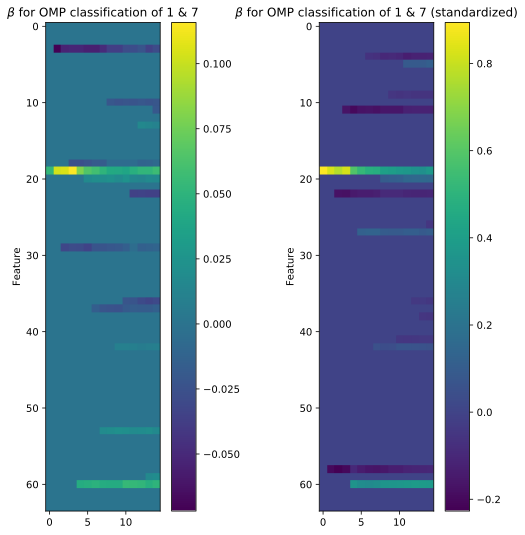

In [13]:
# OMP regression for t = 1,...,15 
T = 15
beta     = omp_regression(X_train, y_train, T)
beta_std = omp_regression(X_train_std, y_train, T)

plt.figure(figsize=(9,9))
plt.subplot(121)
plt.imshow(beta, cmap='viridis')
plt.colorbar()
plt.title('$\\beta $ for OMP classification of 1 & 7')
plt.ylabel('Feature')

plt.subplot(122)
plt.imshow(beta_std,cmap='viridis')
plt.colorbar()
plt.title('$\\beta $ for OMP classification of 1 & 7 (standardized)')
plt.ylabel('Feature')

plt.show()

In [14]:
def prediction(beta_hat, X_test, y_test):
    pred = np.sign(X_test.dot(beta_hat))
    return np.mean(pred == y_test[:,None], axis=0)

In [15]:
accuracy = np.zeros((2,T))
accuracy_std = np.zeros((2,T))

# Test accuracy
accuracy[0]     = prediction(beta, X_test, y_test)
accuracy_std[0] = prediction(beta_std, X_test_std, y_test)

# Training accuracy
accuracy[1]     = prediction(beta, X_train, y_train)
accuracy_std[1] = prediction(beta_std, X_train_std, y_train)

not standard. | t =,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
err_train,0.42,0.95,0.96,0.98,0.99,0.99,0.99,1.00,0.99,0.99,0.99,1.00,1.00,1.00,1.00
err_test,0.54,0.96,0.98,0.97,0.99,0.99,0.99,0.99,1.00,1.00,0.99,1.00,1.00,1.00,1.00


standardized | t =,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
err_train,0.97,0.97,1.00,0.99,1.00,0.99,0.99,0.99,1.00,0.99,0.99,1.00,1.00,1.00,1.00
err_test,0.95,0.98,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


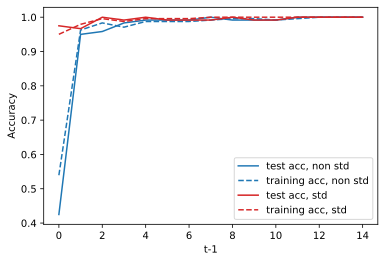

In [16]:
# Table of accuracy evolution
display(pd.DataFrame(
        data = accuracy,
        index = ['err_train', 'err_test'],
        columns = list(range(1,T+1)))
        .rename_axis('not standard. | t =', axis = 'columns'))
    
display(pd.DataFrame(
        data = accuracy_std,
        index = ['err_train', 'err_test'],
        columns = list(range(1,T+1)))
        .rename_axis('standardized | t =', axis = 'columns'))

# Plot accuray evolution.
plt.plot(np.arange(T), accuracy[0], color='tab:blue', label='test acc, non std', )
plt.plot(np.arange(T), accuracy[1], '--', color='tab:blue',label='training acc, non std')
plt.plot(np.arange(T), accuracy_std[0], color='tab:red', label='test acc, std')
plt.plot(np.arange(T), accuracy_std[1], '--', color='tab:red', label='training acc, std')
plt.ylabel('Accuracy')
plt.xlabel('t-1')
plt.legend()
plt.show()

In [17]:
def visualize_pixel(beta, mean=np.ones(64)):
    N, T = beta.shape
    index = list(range(beta.shape[0]))
    ordered = []
    for i in range(T):
        # Get first nonzero element not already seen.
        j = int(np.nonzero(beta[index,i])[0]) 
        # Move from index list to ordered list.
        ordered.append(index.pop(j))
        
    # Find out what the pixel 'votes' for
    mask = beta[ordered,np.arange(T)]*mean[ordered] > 0
    labels = np.zeros(T)
    labels[mask]  = 1
    labels[~mask] = 7
    
    # Convert to 2d indices
    i = np.array(ordered)%8
    j = np.array(ordered)//8
    
    # Plot order of switching on
    img = np.zeros((8,8))
    img[j,i] = 1
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    plt.imshow(img)
    for idx, label in enumerate(ordered):
        plt.text(i[idx], j[idx], idx+1, ha="center", va="center", color="k")
    plt.title('Order of apperance')
    plt.axis('off')
    
    # Plot what each pixel votes for
    plt.subplot(122)
    img = np.zeros((8,8))
    img[j[mask], i[mask]] = 1
    img[j[~mask], i[~mask]] = -1
    plt.imshow(img, cmap='viridis')
    for idx, label in enumerate(labels):
        plt.text(i[idx], j[idx], int(label), ha="center", va="center", color="w")
    plt.title('Voting for digit')
    plt.axis('off')
    plt.show()

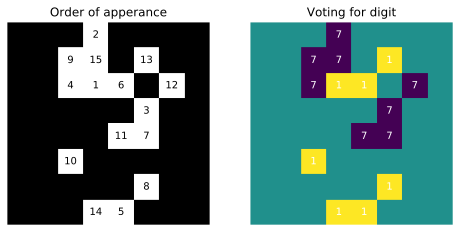

In [18]:
ordered = visualize_pixel(beta)

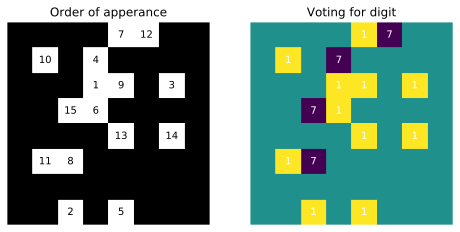

In [19]:
ordered = visualize_pixel(beta_std, mean=np.mean(X_train_std[y_train == 1], axis=0))

## 4.3 One-against-the-rest classification (8 pts)